# Example 2

# Conducting Small-Strain LE Site Response Analyses with pyStrata

Conducting site response analyses on multiple sites concurrently is slightly cumbersome with pyStrata.  
  
 This example is intended to serve as guide for how to construct HVSR, empirical transfer functions, response spectra, and LE computed transfer functions for several sites (and several ground motions) at once.

In [1]:
from datools import site_response_small

## Step 0: Construct Site Profiles

The profile object in pyStrata describes the various Layer objects that constitute a soil profile.
  
  There are several different soil models included in pystrata describing the nonlinear strain compatable properties (e.g., Darendeli (2001), Menq (2004), Kishida (2012)). For this demonstration however, only a generic soil profile will be employed (used subsequently for a Linear Elastic Site Response Analysis).  
    
    
  One can manually construct a profile for a site:


In [2]:
import pystrata
profile = pystrata.site.Profile([
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 1.0, 110.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 34.0, 250.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 55.0, 1200.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 52.0, 490.0),
        pystrata.site.Layer(pystrata.site.SoilType("Soil", 20.0, None, 0.01), 62.0, 700.0),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 20.0, None, 0.01), 0.0, 700.0)
    ])
print(profile)

Or generate several profiles at once using the included DAtools functions.  
  
  First, one downloads the profile information from Kik-Net ([here](https://www.kyoshin.bosai.go.jp/kyoshin/db/index_en.html?all)), and constructs a .txt file with all of the relevant soil property information for as many sites as needed:

```text
FKSH11
vs = [110.00,250.00,1200.00,490.00,700.00] #m/s
OCR = [1.00,1.00,1.00,1.00,1.00]
PI = [10.00,10.00,10.00,10.00,10.00]
uw = 20.00  #kN/m^3
thick = [1.00,33.00,22.00,30.00,32.00]  #m
mean_stress = [6.67, 125.42, 312.24, 488.87, 699.46] #kN/m^2
gwl = 1   #ground water level (m)

KMMH14
(con.)
```

Then, using `parse_site_data()`, construct a Pandas DataFrame:

In [7]:
site_data = site_response_small.parse_site_data('data/Example_2/site_data.txt')
# Print head for each site's data frame
for site in ['FKSH11', 'KMMH14']:
    print(f"Data for {site}:")
    print(site_data[site].head())
    print()

Data for FKSH11:
   Layer      Vs  Mean_Stress  OCR    PI  Unit_Weight  Thickness
0      1   110.0         6.67  1.0  10.0         20.0        1.0
1      2   250.0       125.42  1.0  10.0         20.0       33.0
2      3  1200.0       312.24  1.0  10.0         20.0       22.0
3      4   490.0       488.87  1.0  10.0         20.0       30.0
4      5   700.0       699.46  1.0  10.0         20.0       32.0

Data for KMMH14:
   Layer     Vs  Mean_Stress  OCR    PI  Unit_Weight  Thickness
0      1  110.0        26.67  1.0  10.0         20.0        4.0
1      2  180.0        93.33  1.0  10.0         20.0        6.0
2      3  330.0       167.30  1.0  10.0         20.0       10.0
3      4  480.0       330.34  1.0  10.0         20.0       38.0
4      5  480.0       561.31  1.0  10.0         20.0       30.0



It is then easy to create a soil profile from the DataFrame:

In [4]:
#Only wanting to analyze sites FKSH11 and KMMH14
keys_to_keep = ['FKSH11', 'KMMH14']
site_data = {k: v for k, v in site_data.items() if k in keys_to_keep}


In [5]:
profiles = {}
for site, df in site_data.items():
    uw = df['Unit_Weight'].iloc[0] 
    PI = df['PI'].tolist()
    OCR = df['OCR'].tolist()
    mean_stress = df['Mean_Stress'].tolist()
    thick = df['Thickness'].tolist()
    vs = df['Vs'].tolist()
    sf = 1.0  # Dmin Scale Factor
    
    profile = site_response_small.create_soil_profile(
        uw=uw,
        PI=PI,
        OCR=OCR,
        mean_stress=mean_stress,
        thick=thick,
        vs=vs,
        sf=sf
    )
    profiles[site] = profile

profiles

{'FKSH11': <pystrata.site.Profile at 0x17dcec880>,
 'KMMH14': <pystrata.site.Profile at 0x17dcef160>}

## Step 1: Read Processed Ground Motions

The next step is to bring in the ground motion data that needs to be analyzed in the site resposne analysis. First, the data is brought in as an Obspy Stream object (see Example 1 for more information on Obspy).

Total EW1 traces for FKSH11 combined: 2
Total EW2 traces for FKSH11 combined: 2
Total NS1 traces for FKSH11 combined: 3
Total NS2 traces for FKSH11 combined: 3
Total large surface traces combined for FKSH11: 5
Total large base traces combined for FKSH11: 5
Total EW1 traces for FKSH11 combined: 10
Total EW2 traces for FKSH11 combined: 10
Total NS1 traces for FKSH11 combined: 10
Total NS2 traces for FKSH11 combined: 10
Total small surface traces combined for FKSH11: 20
Total small base traces combined for FKSH11: 20


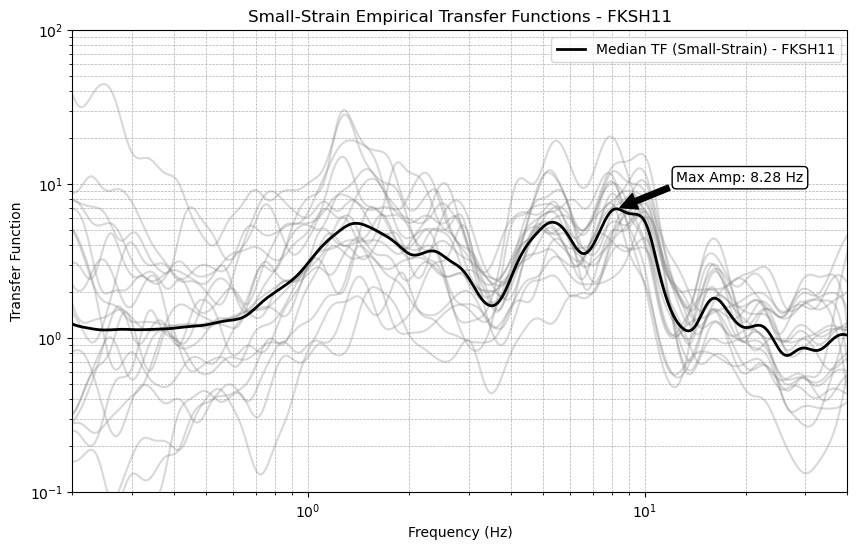

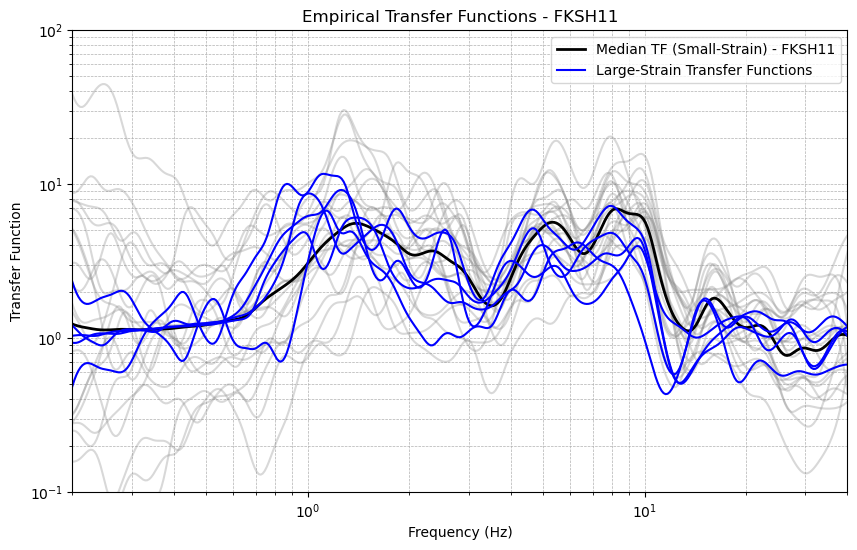

Total EW1 traces for KMMH14 combined: 3
Total EW2 traces for KMMH14 combined: 3
Total NS1 traces for KMMH14 combined: 3
Total NS2 traces for KMMH14 combined: 3
Total large surface traces combined for KMMH14: 6
Total large base traces combined for KMMH14: 6
Total EW1 traces for KMMH14 combined: 9
Total EW2 traces for KMMH14 combined: 9
Total NS1 traces for KMMH14 combined: 10
Total NS2 traces for KMMH14 combined: 10
Total small surface traces combined for KMMH14: 19
Total small base traces combined for KMMH14: 19


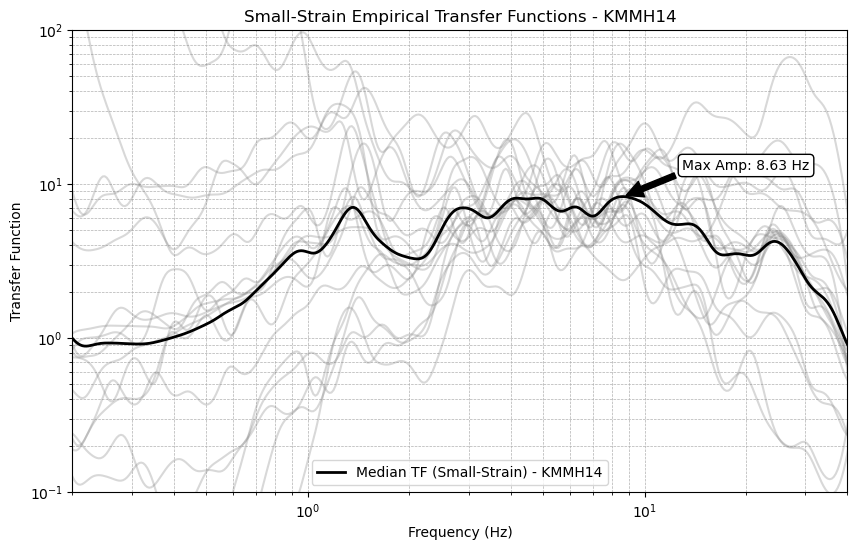

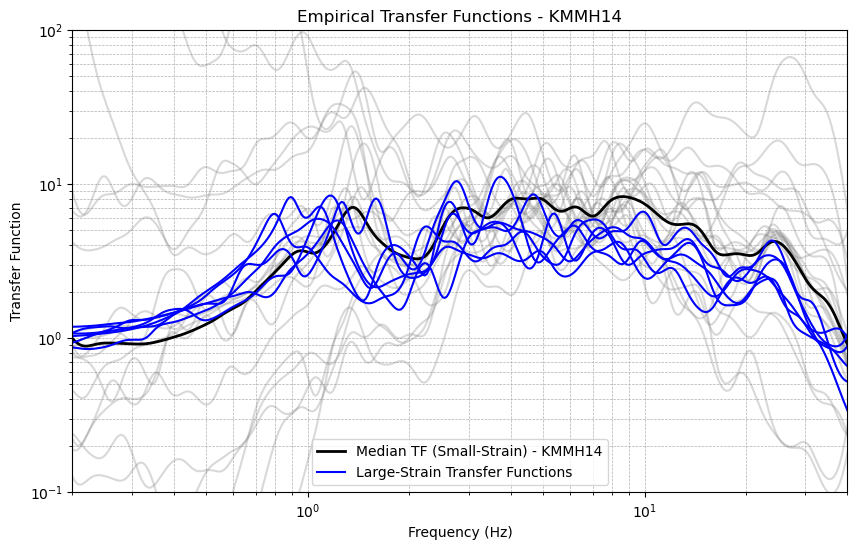

In [ ]:
import numpy as np
freqs = np.logspace(-1,2,num=500)
mp='data/Example_2'
for profile_name, profile in profiles.items():
    base_small_df, surface_small_df, base_large_df, surface_large_df = site_response_small.process_profile(profile_name, profile, mp,freqs=freqs)
    site_response_small.plot_transfer_functions(base_small_df, surface_small_df, base_large_df, surface_large_df, profile_name,freqs=freqs)

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read, Stream
from obspy.signal.util import _npts2nfft
import pykooh                              # ‑‑ smoothing is mandatory now

# ---------------------------------------------------------------------
# helpers
# ---------------------------------------------------------------------
def _read_smallfreq(path: Path, keep_last_two: bool) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df if not keep_last_two else df.iloc[:, [-1, -2]]


def _combine_smallfreqs(paths: list[Path]) -> pd.DataFrame:
    """
    `paths` must contain six csv files in the order:
    [EW1, EW2, NS1, NS2, UD1, UD2]
    (EW1 = full columns, others = keep last 2).

    Returns a DataFrame with added `max_hp`, `low_lp`, `event`.
    """
    ew1, ew2, ns1, ns2, ud1, ud2 = paths
    frames = [
        _read_smallfreq(ew1, False),
        _read_smallfreq(ew2, True),
        _read_smallfreq(ns1, True),
        _read_smallfreq(ns2, True),
        _read_smallfreq(ud1, True),
        _read_smallfreq(ud2, True),
    ]
    total = pd.concat(frames, axis=1)
    total["max_hp"] = total.iloc[:, [11, -9, -7, -5, -3, -1]].max(axis=1)
    total["low_lp"] = total.iloc[:, [12, -11, -9, -7, -5, -3]].min(axis=1)
    total["event"] = total["UniqueID"].str.split(".").str[0]
    return total


def _hvsr_single_motion(st: Stream,
                        hp: float,
                        lp: float,
                        trim_offset: float,
                        trim_len: float,
                        b: int) -> pd.DataFrame:
    """H/V for one three‑component motion (uses pykooh smoothing)."""
    win = Stream()
    for tr in st:
        t0 = tr.stats.starttime + trim_offset
        win.append(tr.copy().trim(t0, t0 + trim_len))

    nfft = _npts2nfft(len(win[0].data))
    dt   = win[0].stats.delta
    freqs = np.fft.fftfreq(nfft, d=dt)[: nfft // 2]

    def _spec(tr):
        return np.abs(np.fft.fft(tr.data, n=nfft)) * dt

    h_tot = np.sqrt(_spec(win[0])[: nfft // 2]**2 + _spec(win[1])[: nfft // 2]**2)
    v_fft = _spec(win[2])[: nfft // 2]

    h_tot = pykooh.smooth(freqs, freqs, h_tot, b=b)
    v_fft = pykooh.smooth(freqs, freqs, v_fft,  b=b)

    band  = (freqs >= hp) & (freqs <= lp)
    return pd.DataFrame({"freqs": freqs[band],
                         "hvsr":  h_tot[band] / v_fft[band]})


# ---------------------------------------------------------------------
# main entry point
# ---------------------------------------------------------------------
def median_hvsr_from_paths(csv_paths: list[str | Path],
                           mseed_dir: str | Path,
                           *,
                           trim_offset: float = 20.0,
                           trim_length: float = 40.0,
                           smooth_b: int = 40,
                           plot: bool = True):
    """
    Parameters
    ----------
    csv_paths  : list of six paths [EW1, EW2, NS1, NS2, UD1, UD2]
    mseed_dir  : directory containing *.MSEED files
    trim_offset, trim_length : window for the HVSR analysis (s)
    smooth_b   : pykooh bandwidth parameter
    plot       : draw individual + median HVSR if True
    """
    csv_paths = [Path(p) for p in csv_paths]
    total     = _combine_smallfreqs(csv_paths)

    hp = total["max_hp"].max()
    lp = total["low_lp"].min()
    print(f"Global hp={hp:.3f} Hz  •  lp={lp:.3f} Hz")

    hvsr_frames = []
    for f in Path(mseed_dir).glob("*.MSEED"):
        st = read(str(f))
        if len(st) < 3:
            continue
        df = _hvsr_single_motion(st, hp, lp,
                                 trim_offset, trim_length, smooth_b)
        hvsr_frames.append(df)
        if plot:
            plt.plot(df["freqs"], df["hvsr"], alpha=0.25, lw=0.8)

    if not hvsr_frames:
        raise RuntimeError("No valid motions found.")

    # stack → median
    all_hvsr = pd.concat(hvsr_frames, ignore_index=True)
    all_hvsr["hvsr"] = np.log(all_hvsr["hvsr"])
    median_df = np.exp(all_hvsr.groupby("freqs").mean().reset_index())

    freqs = median_df["freqs"].to_numpy()
    median  = pykooh.smooth(freqs, freqs, median_df["hvsr"].to_numpy(), b=smooth_b)

    idx_max = np.argmax(median)
    f0, hv0 = freqs[idx_max], median[idx_max]

    if plot:
        plt.plot(freqs, median, color="red", lw=2, label="Median HVSR")
        plt.axvline(f0, color="red", ls="--", label=f"f₀ = {f0:.2f} Hz")
        plt.annotate(f"f₀ = {f0:.2f} Hz", xy=(f0, hv0),
                     xytext=(f0*1.1, hv0*1.1),
                     arrowprops=dict(arrowstyle="->"))
        plt.xscale("log")
        plt.ylim(0.1, 30); plt.xlim(0.1, 30)
        plt.xlabel("Frequency (Hz)"); plt.ylabel("H/V")
        plt.grid(True, which="both", ls="--"); plt.legend(); plt.show()

    return freqs, median, f0


In [ ]:
csvs = [
    r"/data/site/TX123/TX123EW1smallfreqs.csv",
    r"/data/site/TX123/TX123EW2smallfreqs.csv",
    r"/data/site/TX123/TX123NS1smallfreqs.csv",
    r"/data/site/TX123/TX123NS2smallfreqs.csv",
    r"/data/site/TX123/TX123UD1smallfreqs.csv",
    r"/data/site/TX123/TX123UD2smallfreqs.csv",
]

mseed_dir = r"/data/site/TX123/mseed"

freqs, median_hvsr, f0 = median_hvsr_from_paths(csvs, mseed_dir)